In [72]:
import random
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import  iplot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import roc_auc_score,precision_score,recall_score,accuracy_score
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Отключение warnings

In [73]:
warnings.filterwarnings('ignore')

Исследование датасета

In [74]:
df=pd.read_csv("data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

Как видим, данных много, но пропусков нет

Построение матрицы корреляций как первый эта поиска линенозависимости признаков

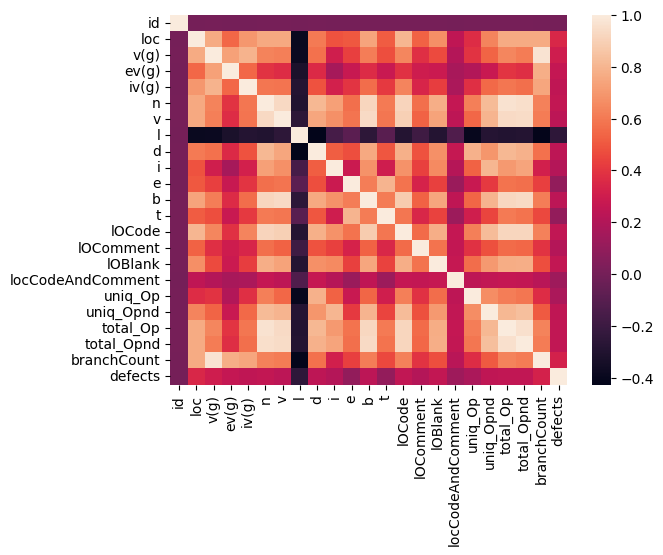

In [75]:
sns.heatmap(df.corr());

Можно заметить, что можно исключить колонки 'v(g)','n','v','total_Opnd', так как они имеют высокую корреляцию с другими.

In [76]:
df=df.drop(columns=['v(g)','n','v','total_Opnd'])

<h3>Исследование целевой метки класса</h3>

Создаём тренировачные и тестовые датасеты, сохраняя соотношение классов, использую стратификацию

In [77]:
y=df['defects'].astype('int')
x=df.drop(columns=['defects','id'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y)

Изображу соотношение классов для тренировочного датасета

Len: 71234
1label count: 16145 0.23
0label count: 55089 0.77


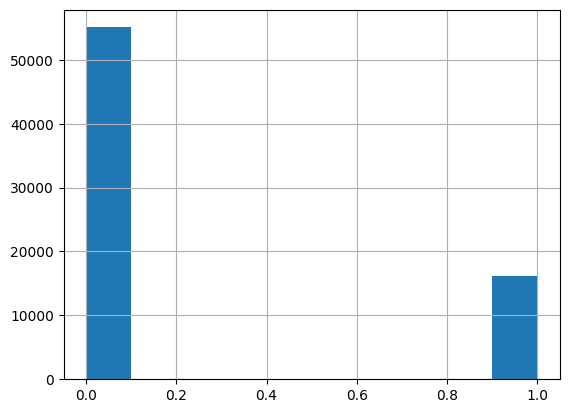

In [78]:
y_train.hist()
print('Len:', len(y_train))
print('1label count:',np.count_nonzero(y_train), np.round(np.count_nonzero(y_train)/len(y_train),2))
print('0label count:',len(y_train)-np.count_nonzero(y_train),np.round((len(y_train)-np.count_nonzero(y_train))/len(y_train),2))

Видно, что классы сильно несбалансированы. От этого нужно избавится чтобы не допустить излиней настройки под доминирующий в количестве класс.
Досемплирую объекты класса 1.

In [79]:
indices_to_add = []
indexes=y_train[y_train==1].index
for i in range(55089-16145):
    indices_to_add.append(indexes[random.randint(0,len(indexes)-1)])
X_train_to_add = x_train.loc[indices_to_add]
y_train_to_add = pd.DataFrame(y_train.loc[indices_to_add],columns=['defects'])

x_train = pd.concat((x_train, X_train_to_add))
y_train = pd.concat((pd.DataFrame(y_train), y_train_to_add))

x_train.index=range(len(x_train))
y_train.index=range(len(y_train))

Изображу пропорции классов в новых сбалансированных датасетах

Len: 110178
1label count: 55089 0.5
0label count: 55089 0.5


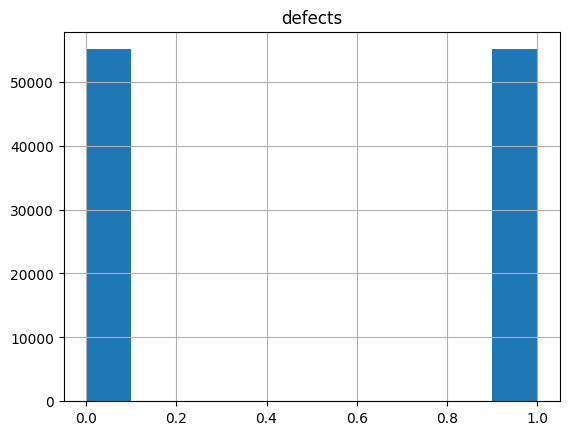

In [80]:
y_train.hist()
print('Len:', len(y_train))
print('1label count:',np.count_nonzero(y_train), np.round(np.count_nonzero(y_train)/len(y_train),2))
print('0label count:',len(y_train)-np.count_nonzero(y_train),np.round((len(y_train)-np.count_nonzero(y_train))/len(y_train),2))

Теперь количество объектов каждого класс равное, что хорошо для построения эффективной модели классификации.

Далее описана функция, использующаясчя для тренировки моделей и вывода метрик.

In [81]:
def fit_test(estimaror, param_grid,x_train,y_train,x_test,y_test,cv=3):

    estimator=GridSearchCV(estimator=estimaror,param_grid=param_grid,cv=cv)
    estimator.fit(x_train, y_train)
    
    y_pred_train=estimator.predict(x_train.values)
    accuracy_train=accuracy_score(y_train, y_pred_train)
    precision_train=precision_score(y_train, y_pred_train)
    recall_train=recall_score(y_train, y_pred_train)
    roc_auc_train=roc_auc_score(y_train, estimator.predict_proba(x_train.values)[:, 1])

    y_pred=estimator.predict(x_test.values)
    accuracy_test=accuracy_score(y_test, y_pred)
    precision_test=precision_score(y_test, y_pred)
    recall_test=recall_score(y_test, y_pred)
    roc_auc_test=roc_auc_score(y_test, estimator.predict_proba(x_test.values)[:, 1])

    print('Best params:', estimator.best_params_)
    print('---------------------------')
    print('Train accuracy:', accuracy_train)
    print('Train precision:', precision_train)
    print('Train recall:', recall_train)
    print('Train rocauc:', roc_auc_train)
    print('---------------------------')
    print('Test accuracy:', accuracy_test)
    print('Test precision:', precision_test)
    print('Test recall:', recall_test)
    print('Test rocauc:', roc_auc_test)
    return estimator, y_pred,accuracy_test,precision_test,recall_test,roc_auc_test


Выведу справку по обучающим данным

In [82]:
x.describe()

,loc,ev(g),iv(g),l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,37.347160,2.845022,3.498826,0.111634,13.681881,27.573007,2.085359e+04,0.179164,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,9.839549
std,54.600401,4.631262,5.534541,0.100096,14.121306,22.856742,1.905714e+05,0.421844,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,14.412769
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.000000,1.000000,1.000000,0.050000,5.600000,15.560000,5.647300e+02,0.030000,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,3.000000
50%,22.000000,1.000000,2.000000,0.090000,9.820000,23.360000,2.256230e+03,0.080000,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,5.000000
75%,42.000000,3.000000,4.000000,0.150000,18.000000,34.340000,1.019324e+04,0.190000,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,11.000000
max,3442.000000,165.000000,402.000000,1.000000,418.200000,569.780000,1.684662e+07,26.950000,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,503.000000


Видно что данные имеют разный масштаб - стоит их привести к одному масштабу

Однако сначала стоит на них посмотреть

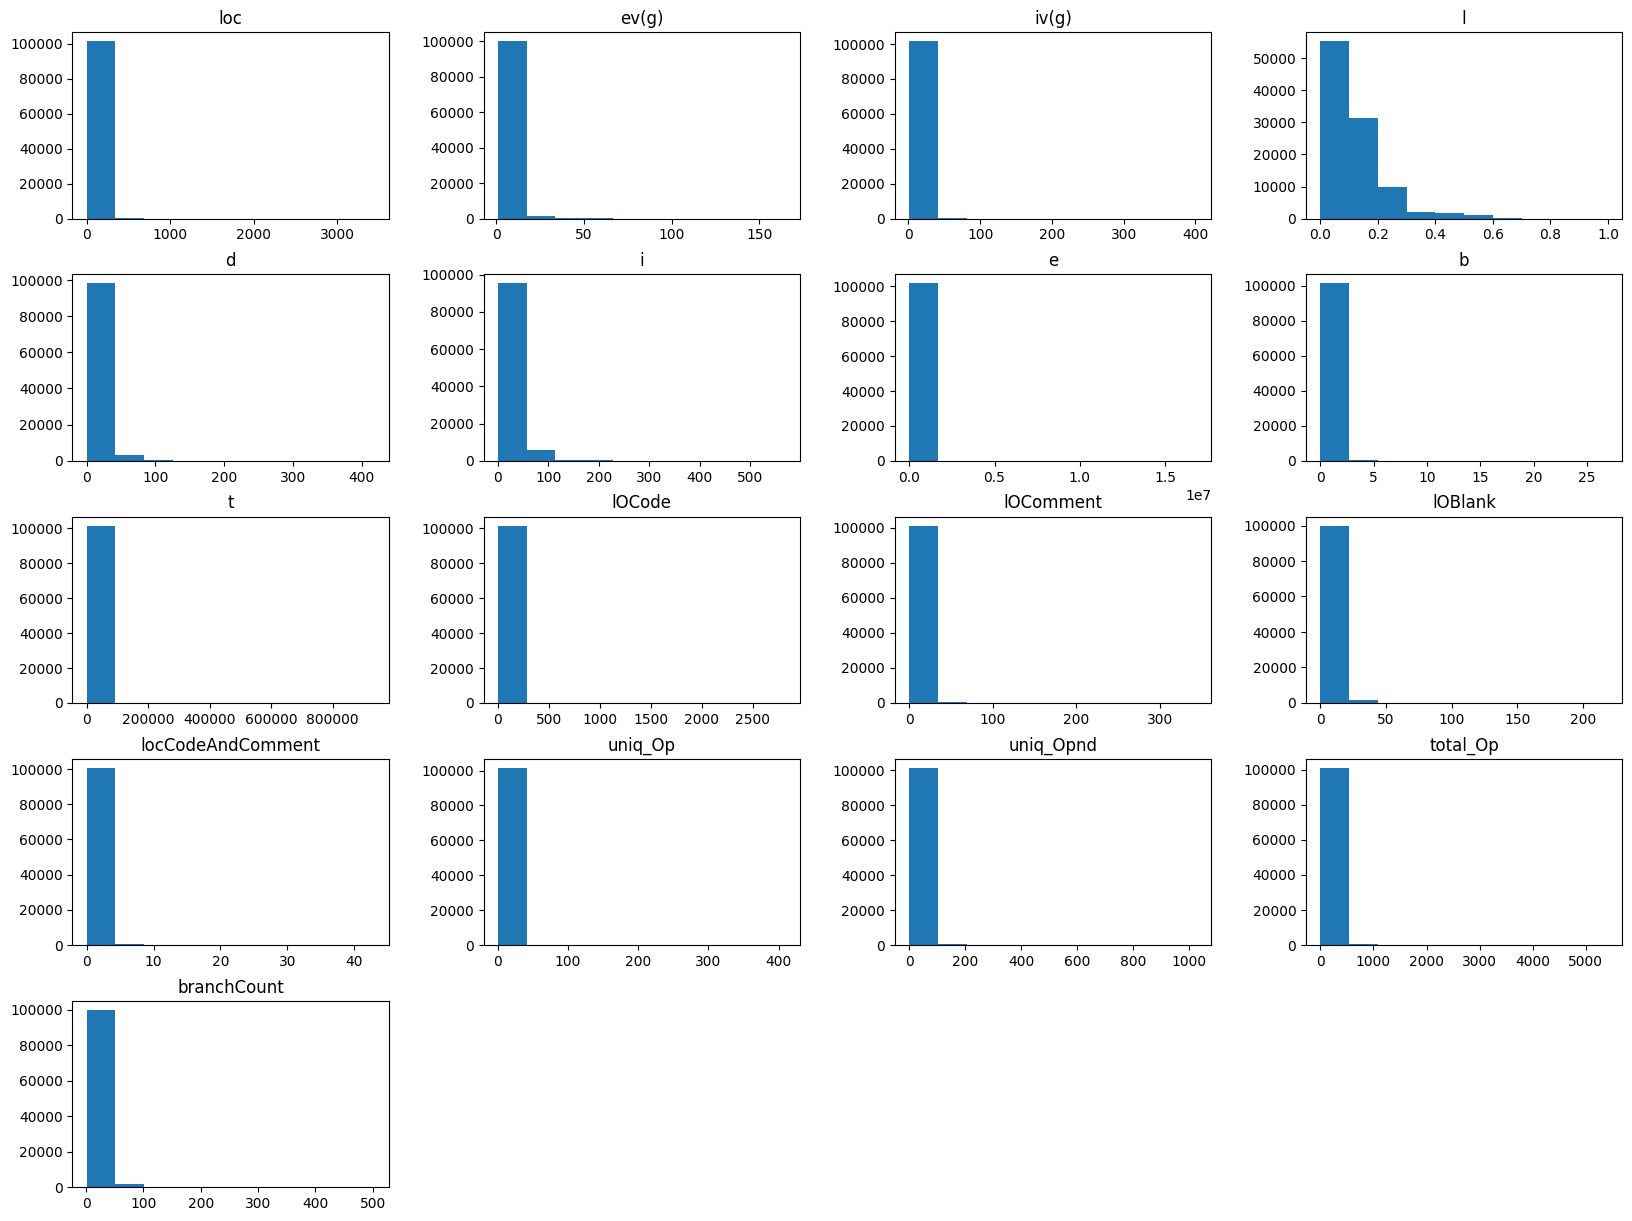

In [83]:
x.hist(figsize=(20,15),grid=False);

Замечу, что данные имеют достаточно плохое распределения для хорошей классификации в исходном виде, так как огромное количество объектов имеют очень схожие признаки.

Проилюстрирую объекты классов при помощи метода TSNE.

In [84]:
x_train

,loc,ev(g),iv(g),l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,branchCount
0,15.0,1.0,2.0,0.11,9.33,13.48,1326.67,0.05,73.70,13,0,1,0,8.0,6.0,16.0,4.0
1,14.0,1.0,1.0,0.08,12.19,16.59,2177.86,0.06,120.99,11,0,1,0,11.0,8.0,27.0,5.0
2,262.0,20.0,20.0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0.0,0.0,0.0,41.0
3,20.0,1.0,2.0,0.09,10.77,20.83,2564.51,0.08,142.47,11,1,4,0,14.0,13.0,31.0,3.0
4,10.0,4.0,1.0,0.09,10.80,10.72,1238.98,0.04,68.83,8,0,0,0,9.0,5.0,20.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110173,19.0,1.0,1.0,0.15,6.67,31.26,1283.11,0.06,71.28,10,5,3,0,8.0,9.0,27.0,1.0
110174,70.0,9.0,7.0,0.04,23.83,46.36,30097.64,0.34,1672.21,53,1,13,0,22.0,36.0,113.0,23.0
110175,14.0,1.0,3.0,0.14,7.08,23.29,1253.98,0.05,69.67,9,0,3,0,10.0,12.0,20.0,7.0
110176,77.0,16.0,2.0,0.04,24.55,56.68,36384.05,0.43,2021.34,59,7,5,0,24.0,42.0,125.0,47.0


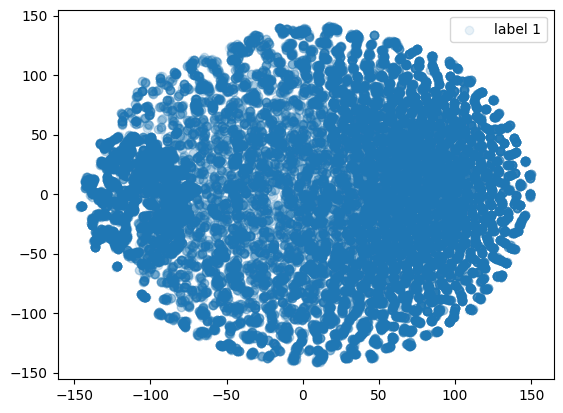

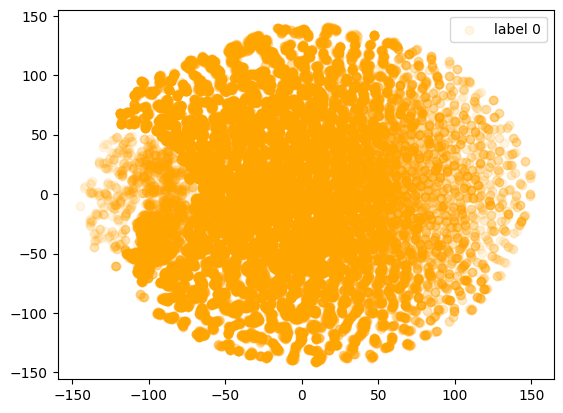

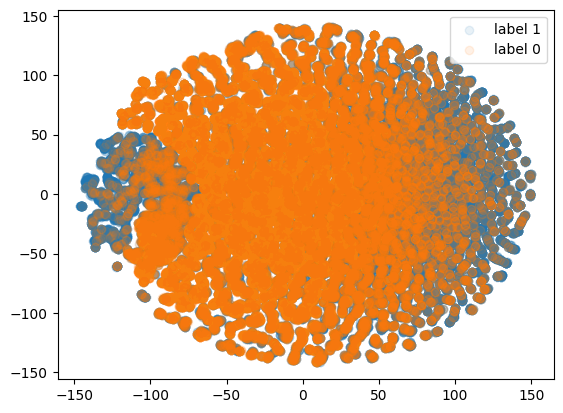

In [87]:
tsne=TSNE()
tsne_x_train=pd.DataFrame(tsne.fit_transform(x_train))

obs=pd.concat((tsne_x_train,y_train), axis=1)

y_1=obs[obs['defects']==1]
y_0=obs[obs['defects']==0]

plt.figure()
plt.scatter(y_1[0],y_1[1],alpha=0.1)
plt.legend(['label 1'])

plt.figure()
plt.scatter(y_0[0],y_0[1],alpha=0.1,c='orange')
plt.legend(['label 0'])


plt.figure()
plt.scatter(y_1[0],y_1[1],alpha=0.1)
plt.scatter(y_0[0],y_0[1],alpha=0.1)
plt.legend(['label 1','label 0']);

Проблема в том что классы сильно пересекаются - нужно подобрать преобразование, которое уменьшит площадь соприкосновения.
Однако надежда на хорошее разделение есть, так как можно заметить что класс 1 в основном сосредоточен по краям полученнго пространства, когда объекты класс 0 сосредоточены в центре.

Применение трансформации Бокса-Кокса:

In [59]:
pt = PowerTransformer(method='yeo-johnson')
x_train=pd.DataFrame(pt.fit_transform(x_train),columns=x_train.columns)
x_test=pd.DataFrame(pt.transform(x_test),columns=x_train.columns)

Признаки приведены к (0,1)-нормальному распределению, насколько это возможно. Восмотрим на сводку по данным и на распределения признаков.

In [60]:
x_train.describe()

,loc,ev(g),iv(g),l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,branchCount
count,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05,1.101780e+05
mean,9.245349e-16,1.774777e-16,-8.337324e-16,1.217579e-16,-2.337133e-16,-3.152293e-16,-1.692229e-16,1.547770e-16,-2.445477e-16,2.063694e-18,1.578726e-16,2.785987e-16,5.675158e-17,1.047325e-16,1.547770e-17,-6.851464e-16,4.870318e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-3.639815e+00,-7.277556e-01,-1.418326e+00,-1.624318e+00,-1.890971e+00,-2.029964e+00,-1.914183e+00,-1.304402e+00,-1.814890e+00,-1.893439e+00,-6.974642e-01,-1.529938e+00,-3.412475e-01,-2.004600e+00,-1.936795e+00,-1.929427e+00,-1.705843e+00
25%,-7.532820e-01,-7.277556e-01,-4.513051e-01,-8.234844e-01,-5.687937e-01,-4.506662e-01,-5.555800e-01,-9.168359e-01,-6.247570e-01,-5.821700e-01,-6.974642e-01,-6.947769e-01,-3.412475e-01,-5.395276e-01,-5.398452e-01,-5.460338e-01,-8.315094e-01
50%,-2.292121e-02,-7.277556e-01,1.057616e-01,-2.471060e-02,5.838732e-03,2.167032e-02,7.507475e-03,-2.050553e-01,2.156196e-02,-2.709825e-03,-6.974642e-01,8.355786e-02,-3.412475e-01,4.776942e-03,-1.608351e-02,6.372098e-03,-3.430724e-02
75%,7.498299e-01,1.131552e+00,7.447820e-01,7.818449e-01,6.598486e-01,5.492539e-01,6.208046e-01,7.798637e-01,6.684996e-01,6.391250e-01,1.186018e+00,6.731390e-01,-3.412475e-01,6.170395e-01,6.132071e-01,6.024645e-01,6.925679e-01
max,3.930385e+00,1.788074e+00,2.886522e+00,2.326145e+00,5.901978e+00,7.173895e+00,5.376007e+00,2.114161e+00,4.518196e+00,6.089366e+00,1.801082e+00,3.650844e+00,2.934995e+00,2.412944e+01,7.928787e+00,5.588340e+00,3.461064e+00


Видим 0 матожидание и 1 отклонение.

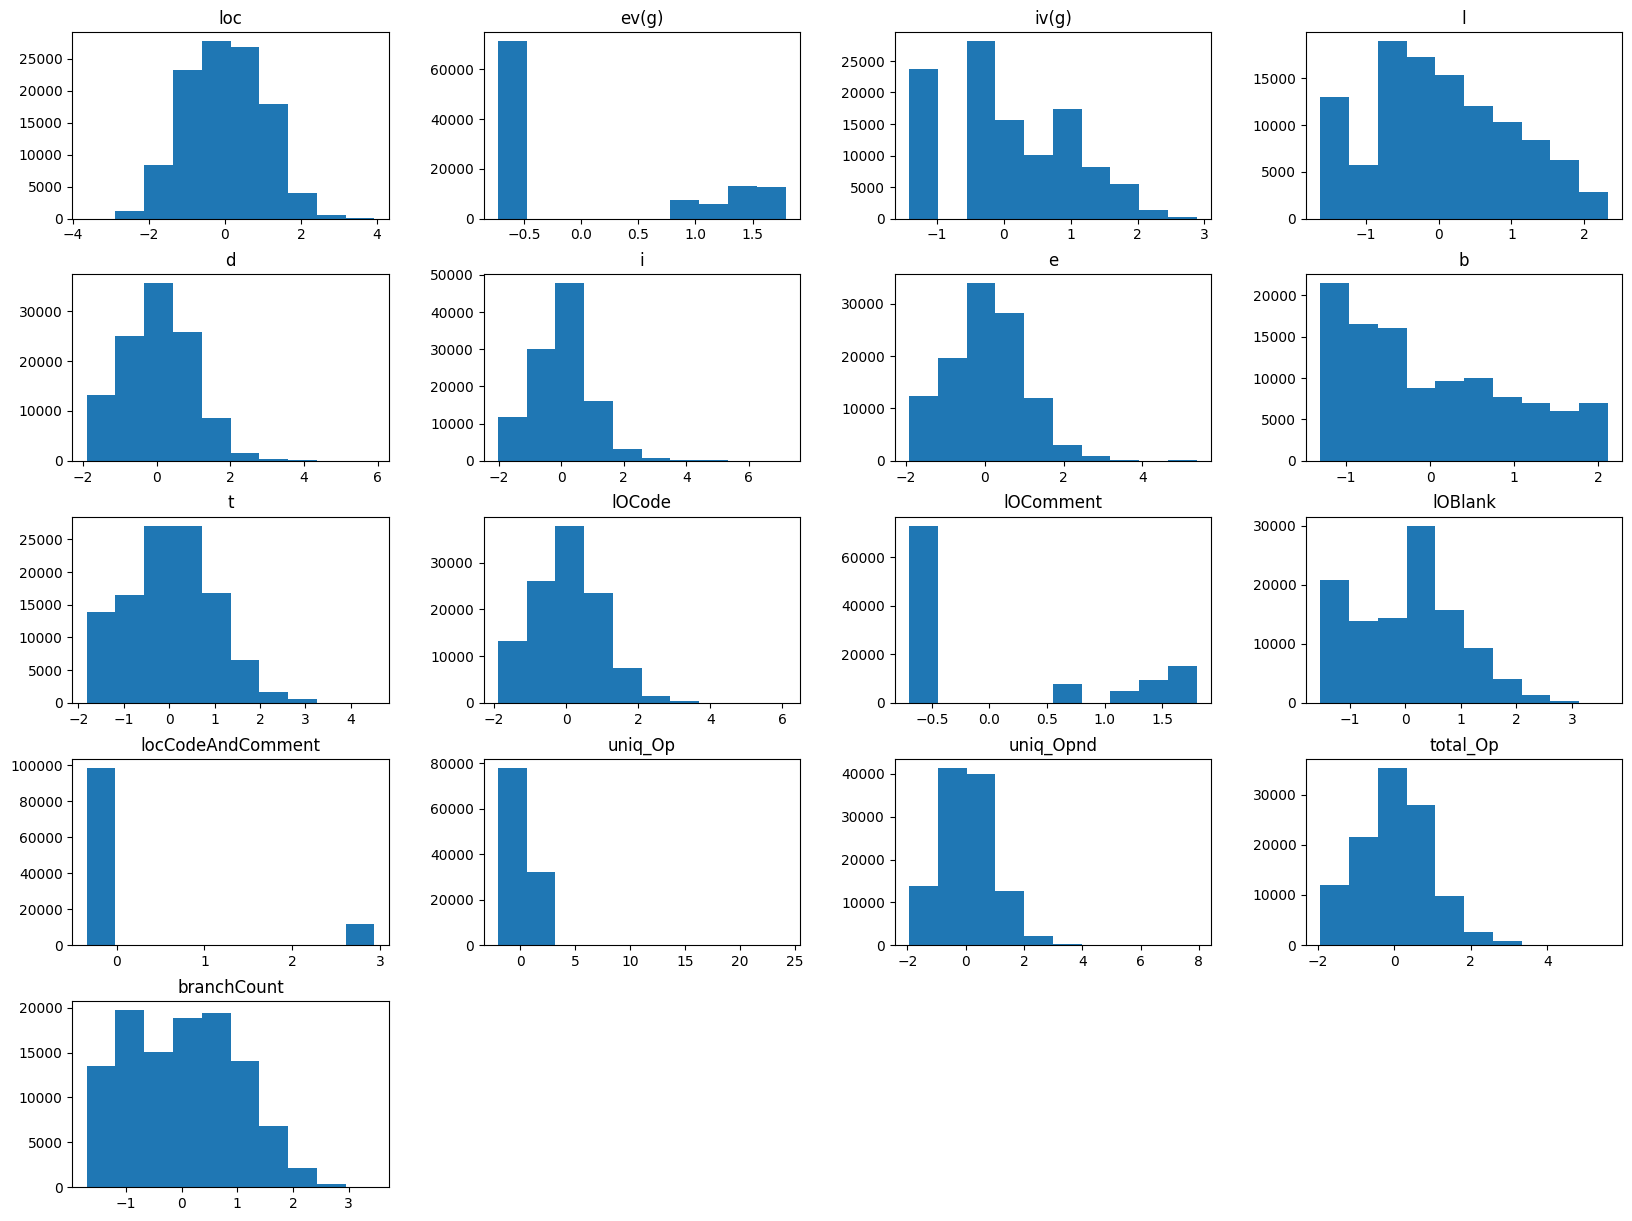

In [61]:
x_train.hist(figsize=(20,15),grid=False);

Распределение признаков стало более разнообразным, что может помочь при классификации.

Снова проилюстрирую объекты классов при помощи метода TSNE.

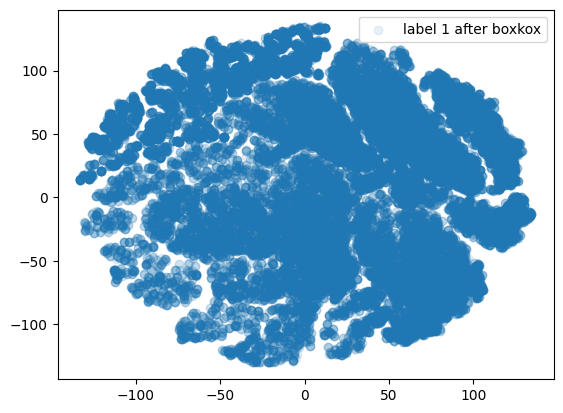

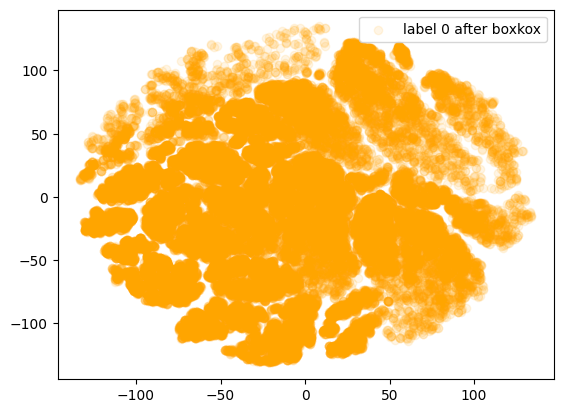

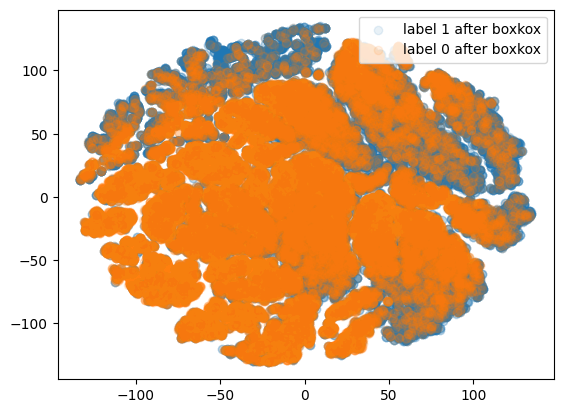

In [62]:
tsne=TSNE()
tsne_x_train=pd.DataFrame(tsne.fit_transform(x_train))
obs_boxkox=pd.concat((tsne_x_train,y_train), axis=1)

y_1=obs_boxkox[obs_boxkox['defects']==1]
y_0=obs_boxkox[obs_boxkox['defects']==0]

plt.figure()
plt.scatter(y_1[0],y_1[1],alpha=0.1)
plt.legend(['label 1 after boxkox'])

plt.figure()
plt.scatter(y_0[0],y_0[1],alpha=0.1,c='orange')
plt.legend(['label 0 after boxkox'])


plt.figure()
plt.scatter(y_1[0],y_1[1],alpha=0.1)
plt.scatter(y_0[0],y_0[1],alpha=0.1)
plt.legend(['label 1 after boxkox','label 0 after boxkox']);

После отрисовки трансформированных данных, нельзя сказать что преобразование Бокса-Кокса сильно улучшило визуальную разделимость данных, но можно заметить области, в которых наблюдается преобладание определённого класс. Данная трансформация хорошо сказалась на итоговых целевых метриках, если сравнивать с изолированным использованием Z или MinMax csler-ов, которые ещё сильнее увеличивают различие в дисперсии признаков, в ту очередь как преобразование Бокса-Кокса выравнивает дисперсии, а также одновременно приводит данные к одному масштабу.

Использование PCA: 

In [36]:
pca=PCA(10)
pca.fit_transform(x_train)
pca.explained_variance_ratio_

array([0.61270992, 0.19201568, 0.05290044, 0.03753663, 0.03190742,
       0.02359818, 0.0176732 , 0.01123177, 0.00626454, 0.00524362])

Видно, что информация концентрируется с нескольких компонентах, что плохо. Ситуация ещё хуже если не использовать преобразование Бокса-Кокса - дам 99% информации сосредотацивается в одной компоненте.

<h3>Подбор модели</h3>

In [25]:
metrics={}

In [26]:
print('L2 LogisticRegression')
params={
    'random_state':[0],
    'fit_intercept':[True],
    'class_weight':['balanced'],
    'penalty':['l2'],
    'C':np.linspace(0,1,10)
}

estimator,y_pred,accuracy_test,precision_test,recall_test,roc_auc_test=fit_test(estimaror=LogisticRegression(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

metrics['L2 LogisticRegression']={'accuracy':accuracy_test,'precision':precision_test,'recall':recall_test,'roc_auc':roc_auc_test}

L2 LogisticRegression
Best params: {'C': 0.1111111111111111, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'random_state': 0}
---------------------------
Train accuracy: 0.7229120151028336
Train precision: 0.7361992690902096
Train recall: 0.6947848027736935
Train rocauc: 0.7889973971350958
---------------------------
Test accuracy: 0.7353991286973042
Test precision: 0.4457244544347663
Test recall: 0.6878161584043937
Test rocauc: 0.7816191124024295


Посмотрю на веса чтобы определить каким признакам модель оттдаёт предпочтение.

In [27]:
coefs=pd.DataFrame(estimator.best_estimator_.coef_[0], x_train.columns, columns=["coef"]).sort_values(by="coef", ascending=False)
coefs

,coef
b,1.327390
loc,1.252716
e,0.684866
l,0.441812
uniq_Op,0.268282
lOBlank,0.171597
branchCount,0.094382
iv(g),0.054910
locCodeAndComment,0.051121
d,0.025160


In [29]:
print('L1 LogisticRegression')
params={
    'random_state':[0],
    'fit_intercept':[True],
    'class_weight':['balanced'],
    'penalty':['l1'],
    'solver':['liblinear'],
    'C':[10],#np.linspace(0.1,10,10)
}


estimator,y_pred,accuracy_test,precision_test,recall_test,roc_auc_test=fit_test(estimaror=LogisticRegression(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

metrics['L1 LogisticRegression']={'accuracy':accuracy_test,'precision':precision_test,'recall':recall_test,'roc_auc':roc_auc_test}

L1 LogisticRegression
Best params: {'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
---------------------------
Train accuracy: 0.722866633992267
Train precision: 0.7367020763847385
Train recall: 0.6936411987874167
Train rocauc: 0.7889818484886196
---------------------------
Test accuracy: 0.7360542435061744
Test precision: 0.4464604681771176
Test recall: 0.6863708628414511
Test rocauc: 0.7815967014449711


In [30]:
coefs=pd.DataFrame(estimator.best_estimator_.coef_[0], x_train.columns, columns=["coef"]).sort_values(by="coef", ascending=False)
coefs

,coef
b,1.356408
loc,1.263224
e,0.852935
l,0.440237
uniq_Op,0.282774
lOBlank,0.172349
branchCount,0.093989
iv(g),0.053375
locCodeAndComment,0.050523
d,0.043698


L1 не занулил никакх признаков - можно было бы отсечь какую-то част по некоторому порогу t, но это не даёт выигрыша в производительности.

In [31]:
print('DecisionTreeClassifier')
params={
    'criterion':['entropy'],
    'random_state':[0],
    'max_depth':[20],
}


estimator,y_pred,accuracy_test,precision_test,recall_test,roc_auc_test=fit_test(estimaror=DecisionTreeClassifier(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

metrics['DecisionTreeClassifier']={'accuracy':accuracy_test,'precision':precision_test,'recall':recall_test,'roc_auc':roc_auc_test}

DecisionTreeClassifier


Best params: {'criterion': 'entropy', 'max_depth': 20, 'random_state': 0}
---------------------------
Train accuracy: 0.8617509847700993
Train precision: 0.8700674082189745
Train recall: 0.8505146217938245
Train rocauc: 0.9430308989262023
---------------------------
Test accuracy: 0.7239018638016312
Test precision: 0.41518759829251856
Test recall: 0.534181240063593
Test rocauc: 0.6460249046279393


Обычное дерево не превзашло Линейные модели

In [32]:
print('RandomForestClassifier')
params={
    'criterion':['gini'],
    'random_state':[0],
    'max_depth':[10],#np.arange(10,100,10),
    'n_estimators':[150],#np.arange(10,1000,100),
    'bootstrap':[True],
    'max_features':[int(len(x_test.columns)/3)],
    'oob_score':[True]
}


estimator,y_pred,accuracy_test,precision_test,recall_test,roc_auc_test=fit_test(estimaror=RandomForestClassifier(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

metrics['RandomForestClassifier']={'accuracy':accuracy_test,'precision':precision_test,'recall':recall_test,'roc_auc':roc_auc_test}

RandomForestClassifier
Best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150, 'oob_score': True, 'random_state': 0}
---------------------------
Train accuracy: 0.7692370527691553
Train precision: 0.7964739745742384
Train recall: 0.7233022926537058
Train rocauc: 0.8387497803020935
---------------------------
Test accuracy: 0.760555537357922
Test precision: 0.4790528233151184
Test recall: 0.6461916461916462
Test rocauc: 0.7856207415890502


Прирост в метриках на тренировочной выборке, но небольшой прирост на тестовой относительно Линейных моделей.

In [33]:
print('XGBClassifier')
params={
    'objective':['binary:logistic'], 
    'n_estimators':[100],
    'learning_rate':[0.1],
    'colsample_bylevel':[1],
    'colsample_bytree':[1],
    'max_depth':[3],
    'n_jobs':[3],
}

estimator,y_pred,accuracy_test,precision_test,recall_test,roc_auc_test=fit_test(estimaror=XGBClassifier(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

metrics['XGBClassifier']={'accuracy':accuracy_test,'precision':precision_test,'recall':recall_test,'roc_auc':roc_auc_test}

XGBClassifier


Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 3, 'objective': 'binary:logistic'}
---------------------------
Train accuracy: 0.7308809381183177
Train precision: 0.7562867735955509
Train recall: 0.681315689157545
Train rocauc: 0.8007736426810343
---------------------------
Test accuracy: 0.7496478757902323
Test precision: 0.46344172894364777
Test recall: 0.6632461338343691
Test rocauc: 0.7861607409854663


Бустинг справился немного лучше РандоомногоЛеса.

In [34]:
print('LinearDiscriminantAnalysis')
params={
    'solver': ['svd'] ,
    'store_covariance': [False, True],
    'tol':[0.1]

}

estimator,y_pred,accuracy_test,precision_test,recall_test,roc_auc_test=fit_test(estimaror=LinearDiscriminantAnalysis(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

metrics['LinearDiscriminantAnalysis']={'accuracy':accuracy_test,'precision':precision_test,'recall':recall_test,'roc_auc':roc_auc_test}

LinearDiscriminantAnalysis


Best params: {'solver': 'svd', 'store_covariance': False, 'tol': 0.1}
---------------------------
Train accuracy: 0.7226851095500009
Train precision: 0.734081325013834
Train recall: 0.69834268184211
Train rocauc: 0.7879246779344291
---------------------------
Test accuracy: 0.7321563103933965
Test precision: 0.4417052826691381
Test recall: 0.6888278652984535
Test rocauc: 0.7802326142299234


Отличная целевая метрика для такой простой модели.

In [69]:
print('KNeighborsClassifier')
params={'n_neighbors':[20]}

estimator,y_pred,accuracy_test,precision_test,recall_test,roc_auc_test=fit_test(estimaror=KNeighborsClassifier(),
         param_grid=params,
         x_train=x_train,
         y_train=y_train,
         x_test=x_test,
         y_test=y_test
       )

metrics['KNeighborsClassifier']={'accuracy':accuracy_test,'precision':precision_test,'recall':recall_test,'roc_auc':roc_auc_test}

KNeighborsClassifier
Best params: {'n_neighbors': 20}
---------------------------
Train accuracy: 0.7604421935413603
Train precision: 0.7650416566604474
Train recall: 0.7517653252010383
Train rocauc: 0.8470035964216677
---------------------------
Test accuracy: 0.7212486488257067
Test precision: 0.4243893166048855
Test recall: 0.6453244688538806
Test rocauc: 0.7525954441418974


Ничего примечательного.

Проанализируем метрики и выберем модель.

In [70]:
metrics_df=pd.DataFrame(metrics).T.sort_values(by='roc_auc')
metrics_df

,accuracy,precision,recall,roc_auc
DecisionTreeClassifier,0.723902,0.415188,0.534181,0.646025
KNeighborsClassifier,0.721249,0.424389,0.645324,0.752595
LinearDiscriminantAnalysis,0.732156,0.441705,0.688828,0.780233
L1 LogisticRegression,0.736054,0.446460,0.686371,0.781597
L2 LogisticRegression,0.735399,0.445724,0.687816,0.781619
RandomForestClassifier,0.760556,0.479053,0.646192,0.785621
XGBClassifier,0.749648,0.463442,0.663246,0.786161


Визуализирую метрики

In [71]:
trace0 = go.Bar(
    x=metrics_df.index,
    y=metrics_df['roc_auc'],
    name='roc_auc'
)

trace1 = go.Bar(
    x=metrics_df.index,
    y=metrics_df['recall'],
    name='recall'
)

trace2 = go.Bar(
    x=metrics_df.index,
    y=metrics_df['precision'],
    name='precision'
)

trace3 = go.Bar(
    x=metrics_df.index,
    y=metrics_df['accuracy'],
    name='accuracy'
)

data = [trace0, trace1, trace2, trace3]
layout = {'title': 'Msdels scores', 'xaxis': {'title': 'Model'}}

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

Можно заметить схожесть по метрикам у топовых моделей (слева направо), метрики отличаются незначительно, оденако в итоге выберу XGBClassifier.

Метод опорных векторов слишком ресурсотребовательный для такого количества данных, поэтому не использовался.

<h3>Creating answer</h3>

In [36]:
x_test=pd.read_csv('data/test.csv')
x_test=x_test.drop(columns=['id'])


df=pd.read_csv('data/train.csv')
y_train=df['defects'].astype('int')
x_train=df.drop(columns=['defects','id'])

indices_to_add_final = []
indexes_final=y_train[y_train==1].index
for i in range(len(y_train)-np.count_nonzero(y_train)):
    indices_to_add.append(indexes_final[random.randint(0,len(indexes_final)-1)])
X_train_to_add = x_train.loc[indices_to_add_final]
y_train_to_add = pd.DataFrame(y_train.loc[indices_to_add_final],columns=['defects'])

x_train = pd.concat((x_train, X_train_to_add))
y_train = pd.concat((pd.DataFrame(y_train), y_train_to_add))


pt = PowerTransformer(method='yeo-johnson')
x_train=pd.DataFrame(pt.fit_transform(x_train),columns=x_train.columns)
x_test=pd.DataFrame(pt.transform(x_test),columns=x_train.columns)

In [37]:
print('XGBClassifier')
params={
    'objective':'binary:logistic', 
    'n_estimators':100,
    'learning_rate':0.1,
    'colsample_bylevel':1,
    'colsample_bytree':1,
    'max_depth':3,
    'n_jobs':3,
    'random_state':11
}

estimaror=XGBClassifier(**params)
estimaror.fit(x_train,y_train)
answer=pd.DataFrame(estimaror.predict_proba(x_test)[:,1],columns=['defects'])
answer.index=range(101763,169605)
answer.to_csv('answer.csv')

XGBClassifier
